# RNN and TCN for Time Series Forecasting
## wrapped by the Darts multi-method package for time series analysis

In [114]:
EPOCH = 300    

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta, TCNModel
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


FC_N = 12               # forecast periods
FC_STRIDE = 10
FC_START = "19580801"   # period at which to split training and validation dataset
DROP = 0.1
LEARN = 0.001


# Prepare the Source Data

In [116]:
## load data
ts = AirPassengersDataset().load()

series = ts  
df = ts.pd_dataframe()
df

component,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [117]:
series.describe()

component,#Passengers
count,144.000
mean,280.299
std,119.966
min,104.000
25%,180.000
50%,265.500
75%,360.500
max,622.000


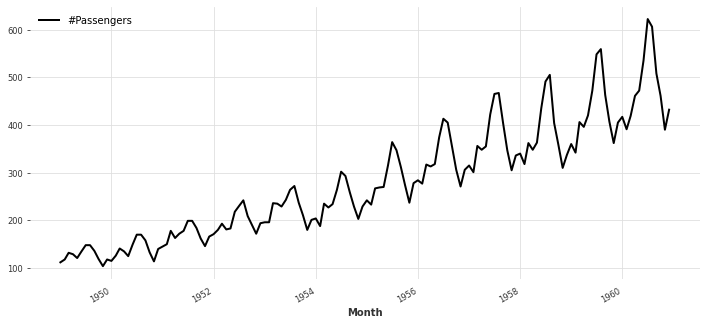

In [118]:
# plot the observations
plt.figure(100, figsize=(12, 5))
series.plot()

In [119]:
# analyze its seasonality

is_seasonal, periodicity = check_seasonality(ts, max_lag=240)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (months) : 12.0
periodicity (~years) : 1.0


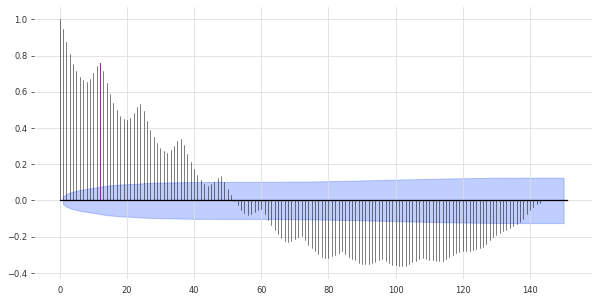

In [120]:
# plot its autocorrelation function
plot_acf(ts, periodicity, max_lag=150)

In [121]:
# split training vs validation datasets
train, val = ts.split_after(pd.Timestamp(FC_START))

In [122]:
# normalize the time series
trf = Scaler()
train_trf = trf.fit_transform(train)
val_trf = trf.transform(val)
ts_trf = trf.transform(ts)

In [123]:
# derive the month from the date strings
month_series = datetime_attribute_timeseries(ts, attribute='month', one_hot=True)

scaler_month = Scaler()
covariates = scaler_month.fit_transform(month_series)

In [124]:
# split training vs validation datasets
train_trf, val_trf = ts_trf.split_after(pd.Timestamp(FC_START))
cov_train, cov_val = covariates.split_after(pd.Timestamp(FC_START))

# Run the Models

In [125]:
# helper function: fit the RNN model

def fit_RNN(model, flavor):
    t_start =  time.perf_counter()
    print("\nbeginning the training of the {0} RNN:".format(flavor))

    res = model.fit(train_trf,
             future_covariates=covariates,
             val_series=val_trf,
             val_future_covariates=covariates,
             verbose=True)

    res_time = time.perf_counter() - t_start
    print("training of the {0} RNN has completed:".format(flavor), f'{res_time:.2f} sec')

    return res

In [126]:
# helper function: plot the predictions

def plot_fitted(pred, act, flavor):
    act2 = act.slice(act.start_time(), pred.end_time())
    plt.figure(figsize=(12,5))
    act2.plot(label='actual')
    pred.plot(label='prediction')
    if flavor == "TCN":
        plt_title = "TCN"
    else:
        plt_title = "RNN: {0} flavor"
    plt.title(plt_title.format(flavor) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.legend();

In [127]:
# helper function: compute accuracy metrics
   
def accuracy_metrics(pred, act):
    act2 = act.slice_intersect(pred)
    pred2 = pred.slice_intersect(act2)
    resid = pred2 - act2
    sr = resid.pd_series()
    sa = act2.pd_series()
    sp = pred2.pd_series()
    res_mape = mape(pred2, act2)
    res_r2 = r2_score(pred2, act2)
    res_rmse = rmse(pred2, act2)
    res_pe = sr / sa
    n_act = len(act2)
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    res_accuracy = {
        "MAPE":res_mape,"RMSPE":res_rmspe, "RMSE":res_rmse, 
        "-R squared":-res_r2}
    return res_accuracy

In [128]:
# set up, fit, run, plot, and evaluate the RNN model

def run_RNN(flavor):

    # set the model up
    model_RNN = RNNModel(
        model=flavor,
        model_name=flavor + str(" RNN"),
        input_chunk_length=periodicity+1,
        training_length=20,
        hidden_dim=20,
        batch_size=16,
        n_epochs=EPOCH,
        dropout=DROP,
        optimizer_kwargs={'lr': LEARN},
        log_tensorboard=True,
        random_state=42,
        force_reset=True)
        
    if flavor == "RNN": flavor = "Vanilla" 

    # fit the model
    fit_RNN(model_RNN, flavor)

    # compute N predictions
    pred = model_RNN.predict(n=FC_N, future_covariates=covariates) 

    # plot predictions vs actual
    plot_fitted(pred, ts_trf, flavor)

    # print accuracy metrics
    res_acc = accuracy_metrics(pred, ts_trf)    
    print(flavor + " : ")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return [pred, res_acc]
    

In [129]:
# set up, fit, run, plot, and evaluate the TCN model

def run_TCN():

    model_TCN = TCNModel(
        input_chunk_length=13, #FC_N+1,
        output_chunk_length=12, #FC_N, 
        n_epochs=EPOCH,
        dropout=DROP,
        dilation_base=2,
        weight_norm=True,
        batch_size=16,
        kernel_size=5,
        num_filters=3,
        optimizer_kwargs={'lr': LEARN},
        log_tensorboard=True,
        force_reset=True,
        random_state=42)


    t_start =  time.perf_counter()
    print("\nbeginning the training of the TCN model")
    model_TCN.fit(
                series=train_trf,
                past_covariates=cov_train,
                val_series=val_trf,
                val_past_covariates=cov_val,
                verbose=True)
    res_time = time.perf_counter() - t_start
    print("training of the TCN has completed: ", f'{res_time:.2f} sec')


    # compute N predictions
    #pred = model_TCN.predict(FC_N, past)
    pred = model_TCN.predict(12,
                series=train_trf,
                past_covariates=cov_train)

    # plot predictions vs actual
    plot_fitted(pred, ts_trf, "TCN")

    # print accuracy metrics
    res_acc = accuracy_metrics(pred, ts_trf)    
    print("TCN:")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return [pred, res_acc]


beginning the training of the TCN model


  0%|          | 0/300 [00:00<?, ?it/s]

training of the TCN has completed:  46.10 sec
TCN:
MAPE : 7.9859
RMSPE : 0.1117
RMSE : 0.0689
-R squared : -0.8330
se : 0.2493

beginning the training of the LSTM RNN:


  0%|          | 0/300 [00:00<?, ?it/s]

training of the LSTM RNN has completed: 79.99 sec
LSTM : 
MAPE : 5.3775
RMSPE : 0.0659
RMSE : 0.0506
-R squared : -0.8955
se : 0.2253

beginning the training of the GRU RNN:


  0%|          | 0/300 [00:00<?, ?it/s]

training of the GRU RNN has completed: 81.33 sec
GRU : 
MAPE : 6.3251
RMSPE : 0.0837
RMSE : 0.0549
-R squared : -0.8896
se : 0.1975

beginning the training of the Vanilla RNN:


  0%|          | 0/300 [00:00<?, ?it/s]

training of the Vanilla RNN has completed: 72.99 sec
Vanilla : 
MAPE : 5.9451
RMSPE : 0.0724
RMSE : 0.0602
-R squared : -0.8276
se : 0.2459


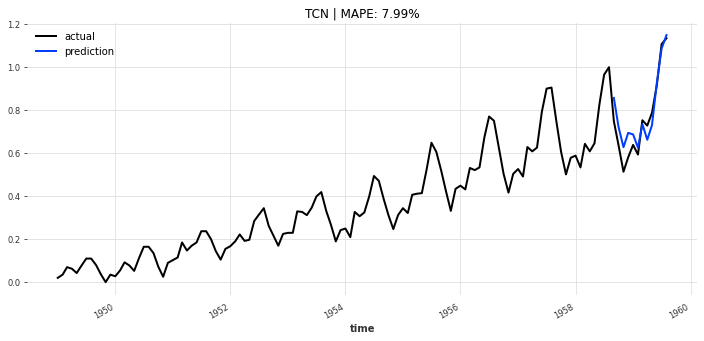

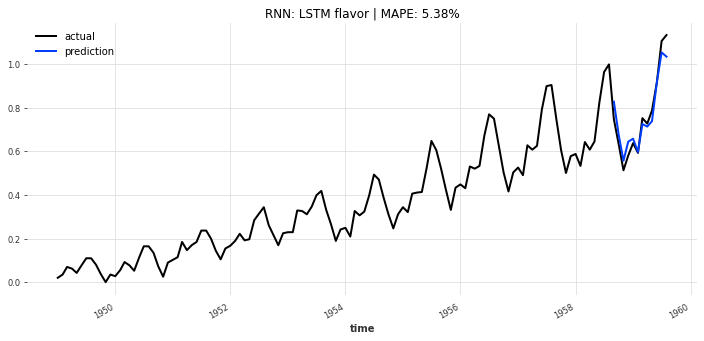

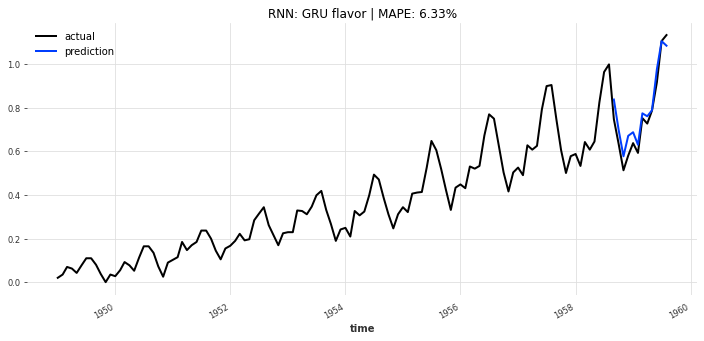

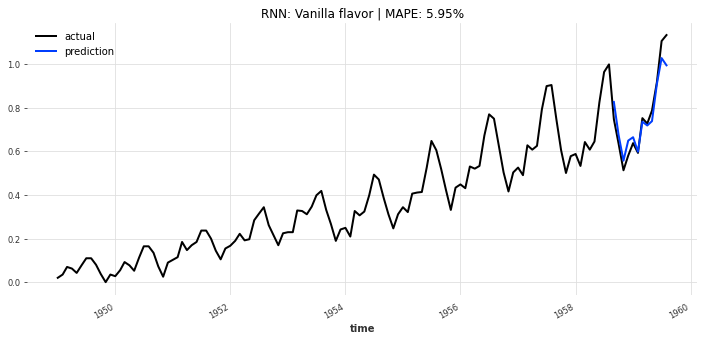

In [130]:
# run TCN and 3 flavors of RNN on the time series:
models = ["TCN", "LSTM", "GRU", "RNN"]

# call the model setup for each of the models
res_models = [run_TCN() if m == "TCN" else run_RNN(m) for m in models]

# Compare with the Theta method

Theta forecast has completed:  4.83 sec
MAPE : 6.5469
RMSPE : 0.0779
RMSE : 30.0678
-R squared : -0.6910
se : 9.1891


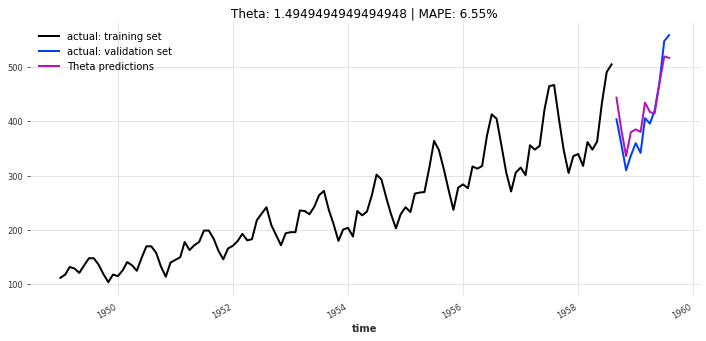

In [131]:
# Theta forecaster

# search space for best theta value: check 100 alternatives
thetas = 2 - np.linspace(-10, 10, 100)

# initialize search
best_mape = float('inf')
best_theta = 0
t_start =  time.perf_counter()
# search for best theta among 100 values, as measured by MAPE
for theta in thetas:
    model = Theta(theta)
    res = model.fit(train)
    pred_theta = model.predict(FC_N)
    res_mape = mape(val, pred_theta)
    if res_mape < best_mape:
        best_mape = res_mape
        best_theta = theta


# fit the model
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred = best_theta_model.predict(FC_N)

# review the Theta results
val2 = val.slice(val.start_time(), pred.end_time())
plt.figure(figsize=(12,5))
train.plot(label='actual: training set')
val2.plot(label='actual: validation set')
pred.plot(label='Theta predictions')
plt.title("Theta: {0}".format(best_theta) + ' | MAPE: {:.2f}%'.format(mape(pred, val)))
plt.legend();

res_time = time.perf_counter() - t_start
res_acc = accuracy_metrics(pred, val)
print("Theta forecast has completed: ", f'{res_time:.2f} sec')
_ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]
results = [pred, res_acc]


In [132]:
# collect the forecasters's accuracy metrics in a dataframe

dict_models = {
    "TCN":res_models[0][1],
    "LSTM":res_models[1][1], 
    "GRU":res_models[2][1],
    "Vanilla":res_models[3][1], 
    "Theta":res_acc}
df_acc = pd.DataFrame.from_dict(dict_models, orient="index").T
pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

,TCN,LSTM,GRU,Vanilla,Theta
MAPE,7.986,5.377,6.325,5.945,6.547
RMSPE,0.112,0.066,0.084,0.072,0.078
RMSE,0.069,0.051,0.055,0.060,30.068
-R squared,-0.833,-0.895,-0.890,-0.828,-0.691
se,0.249,0.225,0.198,0.246,9.189
